# SI 630: Homework 2 Part 4: Attention-based classification

This last part of homework 2 will have you _using_ the vectors we learned from your word2vec implementation to do classification. You should complete the initial word2vec part before before starting on this.

Broadly, this last part of the homework consists of a few major steps:
1. Load in the data, word vectors, and word-indexing
2. Define the attention-based classification network
3. Train your model at least one epoch (2+ is recommended though).
4. Perform exploratory analyses on attention
5. Test the effects of freezing the pre-trained word vectors (see homework PDF for details)

After Step 2, you should be able to train your classifier implementation on a small percent of the dataset and verify that it's learning correctly. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**


### Estimated performance times

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading data, tokenizing, and converting to ids: ~20 seconds
* Training one epoch: ~18 minutes
* Training one epoch using frozen embeddings: ~3 minutes
* Evaluating on dev/test set: ~5 seconds

In [56]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim

import pandas as pd
import pickle
import string

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# Attention plotting
import matplotlib.pyplot as plt

# Load in the necessary parameters from the word2vec code

In [58]:
# Load the word-to-index mapping we used for word2vec and use the same type
# of tokenizer. We'll need to use this to tokenize in the same way and keep 
# the same word-to-id mapping
tokenizer = RegexpTokenizer("\w+")
word_to_index, index_to_word = pickle.load(open("corpus.pkl", "rb"))

# Define the Classifier Model

Just like we did for word2vec, let's define a PyTorch `nn.Module` class here that will contain our classifier.

In [102]:
class DocumentAttentionClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname, retrain_word_embeddings=True):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier, self).__init__()
        
        # Save the input arguments to the state
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.embeddings_fname = embeddings_fname

        
        
        
        # Create the Embedding object that will hold our word embeddings that we
        # learned in word2vec. This embedding object should have the same size
        # as what we learned before. However, we don't to start from scratch! 
        # Once created, load the saved (word2vec-based) parameters into the object
        # using load_state_dict.
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.load_state_dict(torch.load(embeddings_fname))
        self.embedding.weight.requires_grad=retrain_word_embeddings

        
        

        # Define the attention heads. You have two options:
        # 
        # 1) the worse way to implement this is to define your heads using an Embedding
        #    and then access them individually later in forward(). This will be slower
        #    but will probably still work 
        #
        # 2) the ideal way is to think of your attention heads as rows in a matrix--
        #    just like we do for word2vec. While this is kind of the same as how
        #    we represent things like in an Embedding, the key difference is that we
        #    can now use **matrix operations** to calculate the different r and a
        #    vectors, which will be much faster (and less code). To do this, you'll
        #    need to represent the attention heads as a Tensor directly (not a layer)
        #    and make sure pytorch runs gradient descent on these parameters.
        #
        #  It's up to you which to use, but try option 2 first and see what you do 
        #  in the forward() function
        self.attention_heads = torch.FloatTensor(
            self.num_heads, self.embedding_size
        ).uniform_(-0.01, 0.01).clone().detach().requires_grad_(True)
        
        # Define the layer that goes from the concatenated attention heads' outputs
        # to the single output value. We'll push this output value through the sigmoid
        # to get our prediction

        self.linear = torch.nn.Linear(self.num_heads * self.embedding_size, 1)
    

    def forward(self, word_ids):
        
        # Pro Tip™: when implementing this forward pass, try playing around with pytorch
        # tensors in a jupyter notebook by making "fake" versions of them. For example:
        #
        # word_embeds = torch.Tensor([[1,6,2], [9,1,7]])
        #
        # If you have two word embeddings of length 3, how can you define the attention
        # heads to get the 'r' vector? Trying things out in the simple case will let you
        # quickly verify the sequence of operations you want to run, e.g., that you can take
        # the softmax of the 'r' vector to get the 'a' vector and it has the right shape
        # and values
        
        # Hint 1: If you're representing attention using Option 2, most of this code is just 
        #         matrix multiplications

        # Hint 2: Most of your time is going to be spent figuring out shape errors and what
        #         operations you need to do to get the right outputs. This is normal.
        
        # Hint 3: This is the hardest part of this last part of the homework.

        
        # Get the word embeddings for the ids
        W = self.embedding(word_ids)


        # Calcuate the 'r' vectors which are the dot product of each attention head
        # with each word embedding. You should be getting a tensor that has this
        # dot product back out---remember this vector is capturing how much the 
        # head thinks the vector is relevant for the task
        r = self.attention_heads @ torch.transpose(W, 1, 2)



        # Calcuate the softmax of the 'r' vector, which call 'a'. This will give us
        # a probability distribution over the tokens for each head. Be sure to check
        # that the softmax is being calculated over the right axis/dimension of the 
        # data (You should see probability values that sum to 1 for each head's 
        # ratings across all the tokens)   
        sm = nn.Softmax(dim=1)
        a = sm(r)

        # Calculate the re-weighting of the word embeddings for each head's attention
        # weight and sum the reweighted sequence for each head into a single vector.
        # This should give you n_heads vectors that each have embedding_size length.
        # Note again that each head should give you a different weighting of the
        # input word embeddings
        document_vector = a @ W # n_heads x embedding_size
        
        # Create a single vector that has all n_heads' attention-weighted vectors
        # as one single vector. We need this one-long-vector shape so that we 
        # can pass all these vectors as input into a layer.
        #
        # NOTE: if you're doing Option 2 for representing attention, you don't 
        # actually need to create a new vector (which is very inefficient).
        # Instead, you can create a new *view* of the same data that reshapes the
        # different heads' vectors so it looks like one long vector. 
        document_vector = document_vector.view(self.num_heads * self.embedding_size)        

        # Pass the side-by-side attention-weighted vectors through your linear
        # layer to get some output activation.
        #
        # NOTE: if you're feeling adventurous, try adding an extra layer here
        # which will allow you different attention-weighted vectors to interact
        # in making the model decision
        y_hat = torch.sigmoid(self.linear(document_vector))

        
        
        # Return the sigmoid of the output activation *and* the attention 
        # weights for each head. We'll need these later for visualization
        return (y_hat, a)

# Load in the datasets 

You can keep these as pandas data frames.

Convert each dataset into a list of tuples of the form `([word-ids,...], label)`. Both the word ids and the label should be numpy arrays so they will get converted into Tensors by our data loader. Note that you did something very similar for creating the word2vec training data. This process will require tokenizing the data in the same way as you did for word2vec and using the same word-to-id mapping (both of which you loaded/created above).

In [60]:
def tokenize(text):
    text = (text.lower().translate(str.maketrans('','', string.punctuation))
    .replace("\r", " ")
    .replace("\n", " ")
    .replace("\"", "")
    .replace("\'", ""))
    return tokenizer.tokenize(text)  

def process_data(df):
    df["text"] = (
        df["text"].apply(tokenize)
        .apply(
            lambda words: [
                int(word_to_index[word]) 
                if word in word_to_index 
                else int(word_to_index["<UNK>"])
                for word in words
            ]
        )
    )

def process_instance(row, data_list, label=True):
    # function has side effects!
    # appends data into data_list
    if label:
        data_list.append((np.array(row["text"]), np.array([float(row["label"])])))
    else:
        data_list.append((np.array(row["text"]), np.array([int(row["inst_id"])])))

In [61]:
sent_train_df = pd.read_csv("sentiment.train.csv")
sent_dev_df = pd.read_csv("sentiment.dev.csv")
sent_test_df = pd.read_csv("sentiment.test.csv")

train_list = []
dev_list = []
test_list = []

process_data(sent_train_df)
process_data(sent_dev_df)
process_data(sent_test_df)

_ = sent_train_df.apply(lambda r: process_instance(r, train_list), axis=1)
_ = sent_dev_df.apply(lambda r: process_instance(r, dev_list), axis=1)
_ = sent_test_df.apply(lambda r: process_instance(r, test_list, label=False), axis=1)

If this worked you should see XXXX train, XXXX dev, and XXX test instances.

In [62]:
len(train_list), len(dev_list), len(test_list)

(160000, 20000, 20000)

# Build the code training loop

We'll evaluate periodically so before we start training, let's define a function that takes in some evaluation data (e.g., the dev or test sets) and computes the F1 score on that data. 

In [63]:
from sklearn.metrics import f1_score
def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    test_dataloader = DataLoader(eval_data, batch_size=1)
    with torch.no_grad():
        y = []
        y_hats = []
        for data in tqdm(test_dataloader):
            word_ids, label = data
            y_hat, _ = model(word_ids)
            y_hats.append(round(y_hat.item()))
            y.append(label.item())
        return f1_score(y_hats, y)


Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The training code will look surprisingly similar to your word2vec code. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. **see below:** Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

For step 4, in addition to writing the loss, you should write the F1 score on the dev set to the writer as well, using the specified number of steps.

**NOTE:** In this training, you'll use a batch size of 1, which will make your life _much_ simpler.

In [91]:
EMBEDDING_SIZE = 50 
LEARNING_RATE = 5e-5
BATCH_SIZE = 1
EPOCHS = 2
NUM_HEADS = 4
EMBEDDING_FNAME = "word2vec.pt"

In [95]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here

model = DocumentAttentionClassifier(len(word_to_index), EMBEDDING_SIZE, NUM_HEADS, EMBEDDING_FNAME)
writer = SummaryWriter()
loss_values = []
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

dataloader = DataLoader(train_list, batch_size=BATCH_SIZE)

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

loss_sum = 0
for epoch in tqdm(range(EPOCHS)):
    # TODO: use your DataLoader to iterate over the data
    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):

        # NOTE: since you created the data np.array instances,
        # these have now been converted to Tensor objects for us
        word_ids, label = data    
        
        # TODO: Fill in all the training details here
        optimizer.zero_grad()
        y_hat, attention = model(word_ids)
        loss = loss_fn(y_hat.unsqueeze(0).double(), label)
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()
        
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        if step % 500 == 0:
            writer.add_scalar("Loss - Attention", loss_sum, (epoch * len(dataloader)) + step)
            writer.flush()
            loss_sum = 0
        if step % 5000 == 0:
            writer.add_scalar("F1 Score - Attention", run_eval(model, dev_list), (epoch * len(dataloader)) + step)            
            writer.flush()        
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()
writer.close()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

### Model with Frozen Word Embeddings

In [104]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here

model_f = DocumentAttentionClassifier(len(word_to_index), EMBEDDING_SIZE, NUM_HEADS, EMBEDDING_FNAME, retrain_word_embeddings=False)
writer = SummaryWriter()
loss_values = []
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model_f.parameters(), lr=LEARNING_RATE)

dataloader = DataLoader(train_list, batch_size=BATCH_SIZE)

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

loss_sum = 0
for epoch in tqdm(range(EPOCHS)):
    # TODO: use your DataLoader to iterate over the data
    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):

        # NOTE: since you created the data np.array instances,
        # these have now been converted to Tensor objects for us
        word_ids, label = data    
        
        # TODO: Fill in all the training details here
        optimizer.zero_grad()
        y_hat, attention = model_f(word_ids)
        loss = loss_fn(y_hat.unsqueeze(0).double(), label)
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()
        
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        if step % 500 == 0:
            writer.add_scalar("Loss - Attention (Frozen)", loss_sum, (epoch * len(dataloader)) + step)
            writer.flush()
            loss_sum = 0
        if step % 5000 == 0:
            writer.add_scalar("F1 Score - Attention (Frozen)", run_eval(model_f, dev_list), (epoch * len(dataloader)) + step)            
            writer.flush()        
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model_f.eval()
writer.close()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

# Inspecting what the model learned

In this last bit of the homework you should look at the model's attention weights. We've written a visualization helper function below that will plot the attention weights. You'll need to fill in the `get_label_and_weights` method that uses the model to classify some new text and structures the attention output in a way that's specified. 

**NOTE:** most of the code for `get_label_and_weights` is code you've already written above.

In [117]:
def get_label_and_weights(text, word_as_ids=False):
    '''
    Classifies the text (requires tokenizing, etc.) and returns (1) the classification label, 
    (2) the tokenized words in the model's vocabulary, 
    and (3) the attention weights over the in-vocab tokens as a numpy array. Note that the
    attention weights will be a matrix, depending on how many heads were used in training.
    '''
    with torch.no_grad():
        if not word_as_ids:
            words = [
                word 
                if word in word_to_index 
                else "<UNK>" 
                for word in tokenize(text)
            ]
            word_ids = torch.tensor(np.array([word_to_index[word] for word in words])).unsqueeze(0)
        else:
            word_ids = torch.tensor(np.array(text)).unsqueeze(0)
        label, attention = model(word_ids)
        return label, words, torch.transpose(attention.squeeze(), 0, 1)

### Helper functions for visualization

In [110]:
def visualize_attention(words, attention_weights):
    '''
    Makes a heatmap figure that visualizes the attention weights for an item.
    Attention weights should be a numpy array that has the shape (num_words, num_heads)
    '''
    fig, ax = plt.subplots() 
    # Rescale image size based on the input length
    fig.set_size_inches((len(words), 4))    
    im = ax.imshow(attention_weights.T)

    head_labels = [ 'head-%d' % h for h in range(attention_weights.shape[1])]
    ax.set_xticks(np.arange(len(words))) # , labels=words)
    ax.set_yticks(np.arange(len(head_labels))) #, labels=head_labels)

    # Rotate the word labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Add the words and axis labels
    ax.set_yticklabels(labels=range(attention_weights.shape[1]), fontsize=16)
    ax.set_ylabel('Attention Head', fontsize=16)
    ax.set_xticklabels(labels=words, fontsize=16)

    # Add a color bar to show probability scaling
    cb = fig.colorbar(im, ax=ax, label='Probability', pad = 0.01)
    cb.ax.tick_params(labelsize=16)
    cb.set_label(label='Probability',size=16)
    fig.tight_layout()
    plt.show()

Example messages to try visualizing.

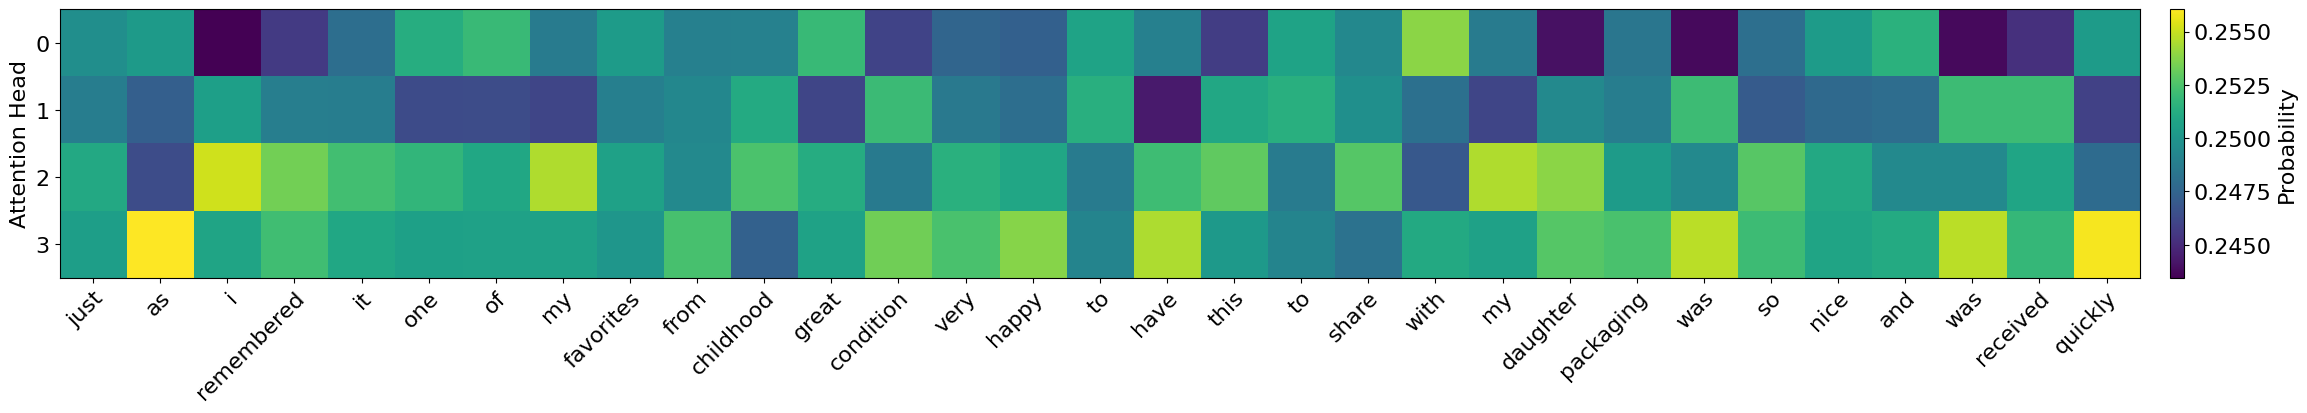

In [107]:
s = 'Just as I remembered it, one of my favorites from childhood! Great condition, very happy to have this to share with my daughter. Packaging was so nice and was received quickly.'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

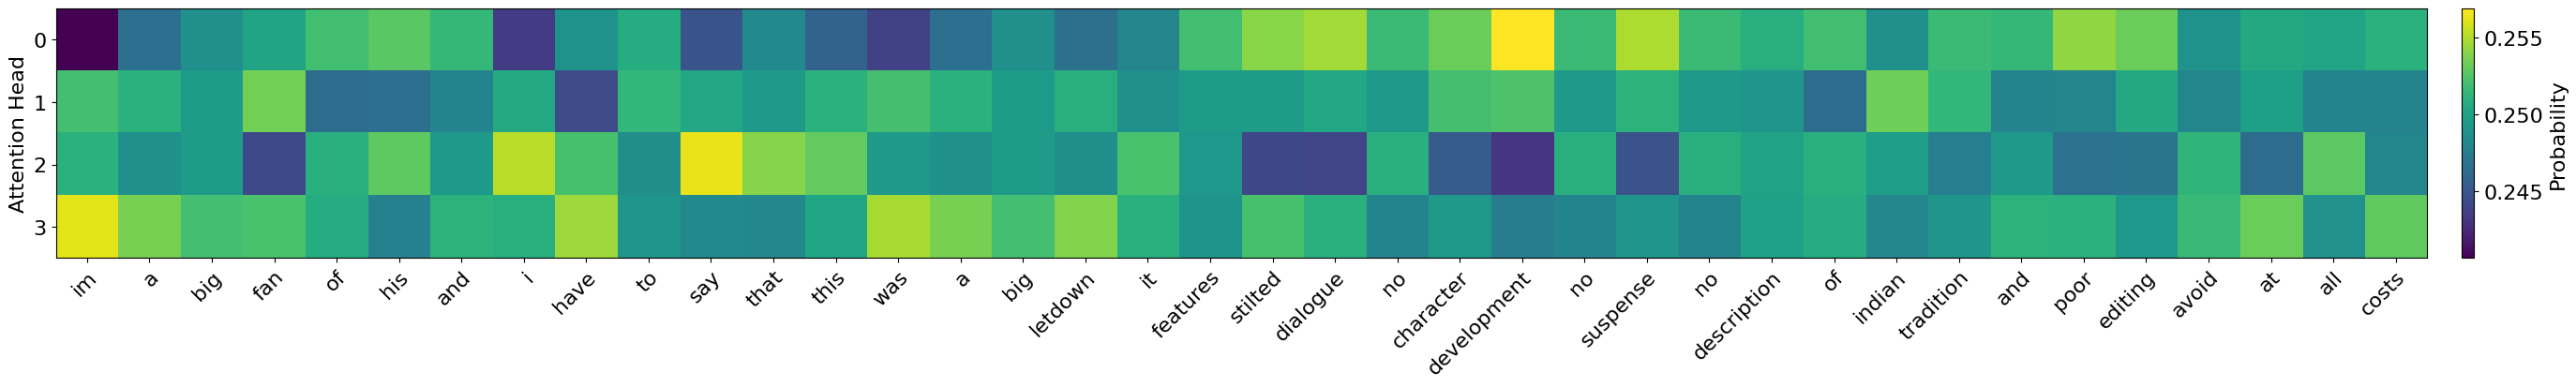

In [108]:
s = '''
I'm a big fan of his, and I have to say that this was a BIG letdown. It features: Stilted dialogue, no character development, no suspense, no description of Indian tradition and poor editing.\n\nAvoid at all costs.
'''
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

In [112]:
sent_dev_df.sample(5)

,text,label
10650,"[90, 206, 720, 196, 491, 21628, 171, 47, 156, ...",0
2041,"[1215, 707, 24, 0, 21, 189, 3027, 1289, 7, 262...",0
8668,"[209, 66, 24, 408, 95, 1036, 30429, 2178, 189,...",0
1114,"[29, 48, 217, 5065, 261, 4667, 18300, 0, 42, 2...",0
13902,"[50, 395, 4, 611, 2831, 4016, 7238, 4, 2524, 4...",0


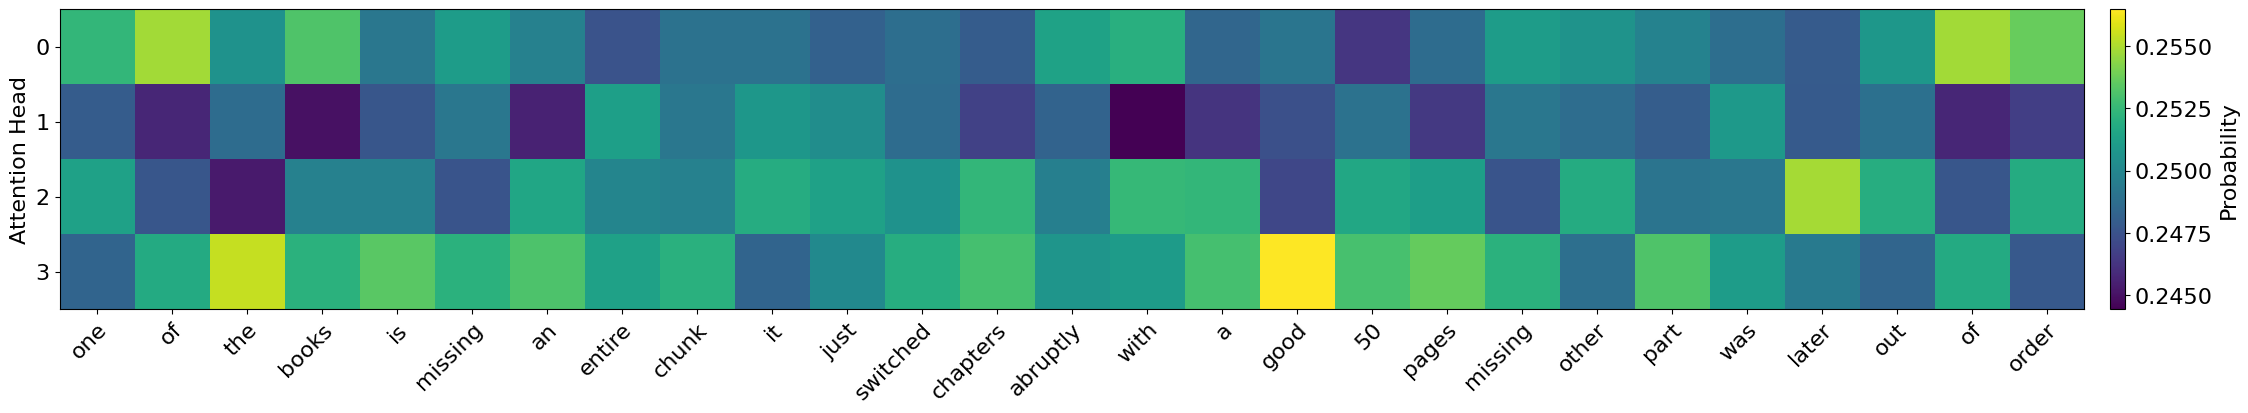

In [194]:
for s in sent_dev_df[sent_dev_df["label"] == 0].sample(1)["text"]:
    words = [index_to_word[index] for index in s]
    pred, tokens, attn = get_label_and_weights(" ".join(words))
    visualize_attention(tokens, attn)

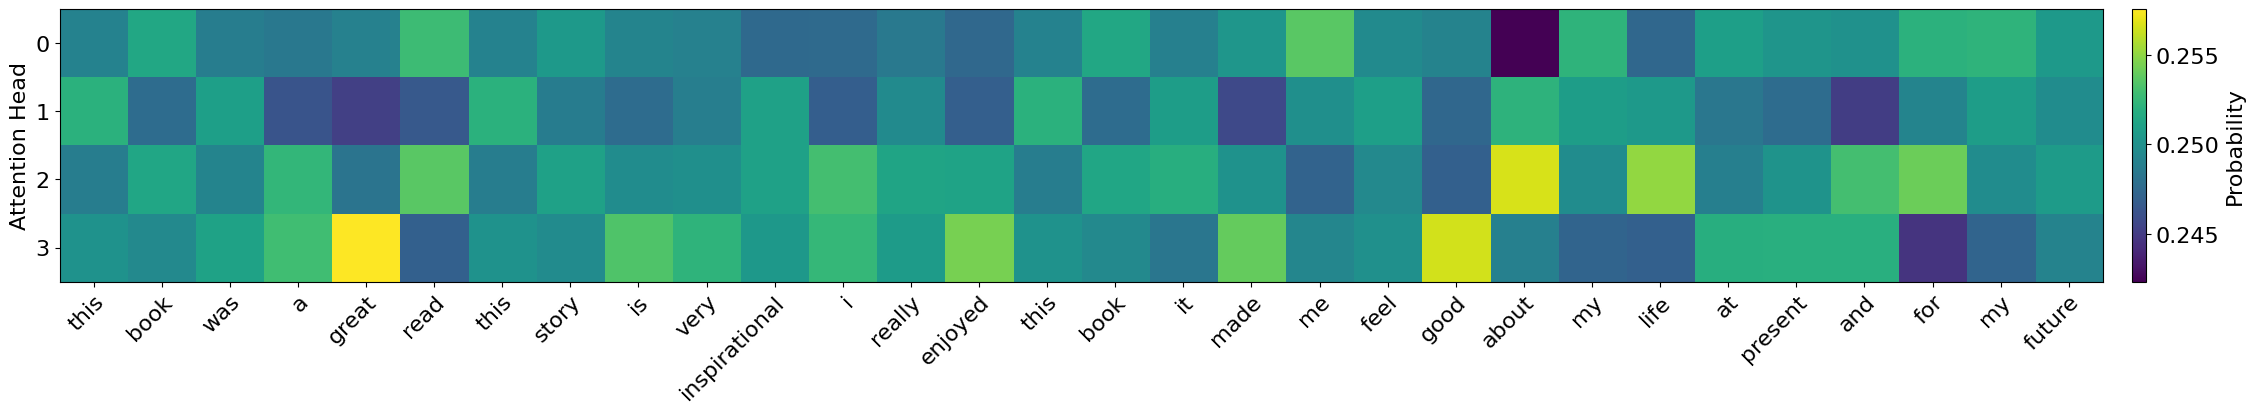

In [195]:
for s in sent_dev_df[sent_dev_df["label"] == 1].sample(1)["text"]:
    words = [index_to_word[index] for index in s]
    pred, tokens, attn = get_label_and_weights(" ".join(words))
    visualize_attention(tokens, attn)

## Predict on Test set

In [134]:
test_dataloader = DataLoader(test_list, batch_size=1)
with torch.no_grad():
    y = []
    y_hats = []
    inst_ids = []
    for data in tqdm(test_dataloader):
        word_ids, inst_id = data
        y_hat, _ = model_f(word_ids)
        y_hats.append(round(y_hat.item()))
        inst_ids.append(round(inst_id.item()))
    pred = pd.DataFrame({"inst_id": inst_ids, "prediction": y_hats})
pred

  0%|          | 0/20000 [00:00<?, ?it/s]

,inst_id,prediction
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
19995,19995,1
19996,19996,1
19997,19997,0
19998,19998,1


In [135]:
pred.to_csv("part4-pred_3.csv", index=False)

In [136]:
!head part4-pred.csv

inst_id,prediction
0,0
1,1
2,0
3,1
4,0
5,1
6,1
7,1
8,0


# Optional TODOs:

### How many instances do we need to learn?

Since the word2vec vectors capture word meaning, do we need to see a lot of examples to train an effective classifier? Maybe we can get away with fewer (or not?). Try making a plot that shows the performance of training on 1 epoch with varying numbers of training examples. What if we just had 10 examples? 100? 1000? 

### Add more layers to the network

This is the second easiest one, but can be fun. What if you add more layers after you aggregate? Does letting the different attention heads' representations interact give better performance? Find out!

### Change the learning rate dynamically

We have a fixed learning rate, but what if we wanted to decrease the learning rate as the model starts to converge? In many cases, this can help the model take smaller but more precise steps towards the best possible parameters. PyTorch supports this with _learning rate schedulers_ that tell pytorch how and when to change the learning rate. See if you can get a better performance using a scheduler!

### Add support for batch sizes > 1

This is non-trivial but will increase training speed _a lot_. The main issue with increasing batch sizes is that our input sequences (the word ids) in a batch will have different lengths. Under the hood, pytorch is turning your code into a series of very fast matrix operations. However, if those matrices suddenly have difference sizes, the math no longer works. As a result developers (like us) have to do a few things:

* We need to _pad_ the sequences with empty values so that all sequences have the same length. You could do this by  adding an extra word ID that is the "empty token" and make sure its values are set to 0 (so it won't interact with anything)

* Set up a collate function in our DataLoader that automatically pads each batch's data based on the longest length in the batch

* At inference time, it's also efficient to mask part of the sequence that's the padded part so we ignore the computations for that part in anything downstream. Depending on how you set it up, you may be able to avoid this step.

If you want to dig into this, you might see some of the documentation around packed and padded sequences in pytorch. You won't need to use these functions but they can provide more context for what's happening and why.


### Add positional information to the word embeddings

Right now our model doesn't know much about which order the words are in. What if we helped the model in this? One way that people have done this is to _add_ some positional embedding to the word embedding, where the positional embedding represents which position in the sequence is in. There are many complicated schemes for this, but one potential idea is to _learn the positional embeddings_. You would keep a separate `Embedding` object for positions with the number of positions up to the length of your longest sequence in the data. Then for the word in the first position, you add `position_embeddings(0)` to it. You can definitely speed that up by passing in a sequence of the positions in the current input and, conveniently, pytorch will let you easily add all the position embeddings to the word embeddings easily (no for loop required).

Will it help here? I have no idea but I'm curious.


**No extra credit is given for these; they're just for folks who want to explore more**